In [ ]:
import base64
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, Gate
from typing import List
from gymnasium.spaces import Box
from rl_qoc.qua import QMEnvironment, QMConfig
from rl_qoc.qua.iqcc import *
from iqcc_calibration_tools.quam_config.components import Quam, Transmon
from qiskit_qm_provider import (
    FluxTunableTransmonBackend,
    QMInstructionProperties,
    InputType,
    ParameterPool,
    IQCCProvider
)
from qiskit_qm_provider.backend.backend_utils import add_basic_macros_to_machine
from rl_qoc.agent.ppo_config import (
    TotalUpdates,
    TrainingConfig,
)
from rl_qoc import (
    RescaleAndClipAction,
    ChannelReward,
    StateReward,
    CAFEReward,
    ExecutionConfig,
    QEnvConfig,
    BenchmarkConfig,
    StateTarget,
    GateTarget,
    PPOConfig,
    ParametricGateContextWrapper
)
from rl_qoc.helpers import add_custom_gate
from rl_qoc.helpers import load_from_yaml_file

import json
import os
import sys
from pathlib import Path
from gymnasium.wrappers import RescaleObservation, FlattenObservation

from rl_qoc.qua.pi_pulse_reward.pi_pulse_reward import PiPulseReward
from rl_qoc.qua.qua_ppo import CustomQMPPO

backend_name = "arbel"
iqcc_provider = IQCCProvider()
machine = iqcc_provider.get_machine(backend_name)
add_basic_macros_to_machine(machine)
backend = iqcc_provider.get_backend(machine)
print(backend.target)


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/helpers/__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")


2025-11-27 19:14:38,536 - qm - INFO     - Starting session: 17dd4412-2093-44ba-b187-e10c11b03e77
2025-11-27 19:14:38 INFO Starting session: 17dd4412-2093-44ba-b187-e10c11b03e77
Target: Qiskit Backend for Quantum Abstract Machine (Quam) of arbel
Number of qubits: 18
Instructions:
	x
		(0,):
			Duration: 4.8e-08 sec.
		(1,):
			Duration: 4.8e-08 sec.
		(2,):
			Duration: 4.8e-08 sec.
		(3,):
			Duration: 4.8e-08 sec.
		(4,):
			Duration: 4.8e-08 sec.
		(5,):
			Duration: 4.8e-08 sec.
		(6,):
			Duration: 4.8e-08 sec.
		(7,):
			Duration: 4.8e-08 sec.
		(8,):
			Duration: 4.8e-08 sec.
		(9,):
			Duration: 4.8e-08 sec.
		(10,):
			Duration: 4.8e-08 sec.
		(11,):
			Duration: 4.8e-08 sec.
		(12,):
			Duration: 4.8e-08 sec.
		(13,):
			Duration: 4.8e-08 sec.
		(14,):
			Duration: 4.8e-08 sec.
		(15,):
			Duration: 5.2e-08 sec.
		(16,):
			Duration: 4.8e-08 sec.
		(17,):
			Duration: 4.8e-08 sec.
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
		(

/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/flux_tunable_transmon_backend.py:56: UserWarning: qiskit.pulse is not available, channel mapping will not be set.
  warnings.warn("qiskit.pulse is not available, channel mapping will not be set.")


In [2]:
path = "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/sync_hook_iqcc/rx_cal"
agent_config_path = os.path.join(path, "agent_config.yaml")
ppo_config = load_from_yaml_file(agent_config_path)


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: List[Parameter], q_reg: QuantumRegister, **kwargs
):

    physical_qubits: List[int] = kwargs["physical_qubits"]
    backend: FluxTunableTransmonBackend = kwargs["backend"]

    # TODO: Enter your custom parametric QUA macro here
    def qua_macro(amp):
        qubit: Transmon = backend.get_qubit(physical_qubits[0])
        qubit.xy.play("x180", amplitude_scale=amp)

    # Create a custom gate with the QUA macro
    custom_x = Gate("x_cal", 1, params)
    instruction_prop = QMInstructionProperties(qua_pulse_macro=qua_macro)
    qc = add_custom_gate(qc, custom_x, q_reg, params, physical_qubits, backend, instruction_prop)
    return qc


physical_qubits = (0,)

target_name = "rx"
target = GateTarget(gate=target_name, physical_qubits=physical_qubits)
reward =  ChannelReward()

# target_name = "1"
# target = StateTarget(state=target_name, physical_qubits=physical_qubits)
# reward =  StateReward()


# Action space specification
param_bounds = [(-1.98, 2.0)]  # Can be any number of bounds

# Environment execution parameters
seed = 1203  # Master seed to make training reproducible
batch_size = 32  # Number of actions to evaluate per policy evaluation
n_shots = 50  # Minimum number of shots per fiducial evaluation
pauli_sampling = 100  # Number of fiducials to compute for fidelity estimation (DFE only)
n_reps = [1, 3, 5]  # Number of repetitions of the cycle circuit
num_updates = TotalUpdates(50)
input_type = InputType.INPUT_STREAM


def create_action_space(param_bounds):
    param_bounds = np.array(param_bounds, dtype=np.float32)
    lower_bound, upper_bound = param_bounds.T
    return Box(low=lower_bound, high=upper_bound, shape=(len(param_bounds),), dtype=np.float32)


action_space = create_action_space(param_bounds)

backend_config = QMConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    input_type=input_type,
    verbosity=2,
    parametrized_circuit_kwargs={"physical_qubits": physical_qubits, "backend": backend},
    num_updates=num_updates.total_updates,
)
execution_config = ExecutionConfig(
    batch_size=batch_size,
    sampling_paulis=pauli_sampling,
    n_shots=n_shots,
    n_reps=n_reps,
    seed=seed,
)
q_env_config = QEnvConfig(
    target=target,
    backend_config=backend_config,
    action_space=action_space,
    execution_config=execution_config,
    reward=reward,
    benchmark_config=BenchmarkConfig(0),
)  # No benchmark for now

q_env = QMEnvironment(training_config=q_env_config)
q_env = ParametricGateContextWrapper(q_env, {})
q_env = FlattenObservation(q_env)
q_env = RescaleObservation(q_env, -1.0, 1.0)
rescaled_env = RescaleAndClipAction(q_env, -1.0, 1.0)
u_env = rescaled_env.unwrapped


/Users/arthurostrauss/Documents/.venv/lib/python3.13/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/arthurostrauss/Documents/.venv/lib/python3.13/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [3]:
u_env.target.all_context_parameters

[{Parameter(ϴ): None}]

In [4]:
rescaled_env.reset()

(array([0.20325232], dtype=float32),
 {'reset_stage': True, 'step': 1, 'gate_index': 0, 'truncation_index': 0})

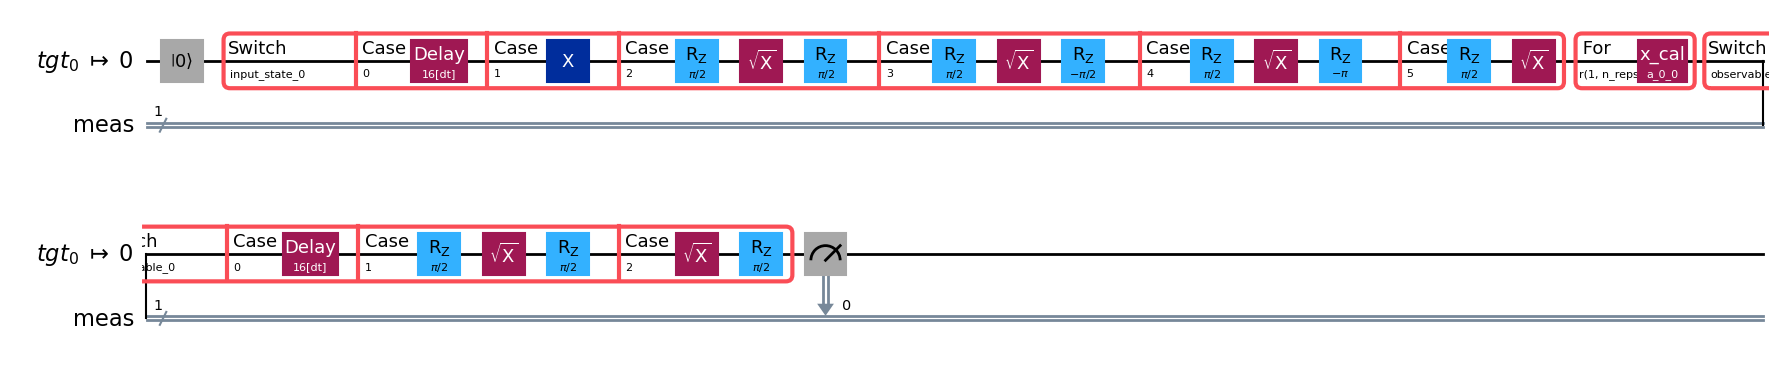

In [5]:
u_env.real_time_transpiled_circuit.draw("mpl")

In [17]:
sync_hook_path = generate_sync_hook(
    rescaled_env,
    ppo_config=ppo_config,
    output_dir=path
    
)
print(f"Sync hook file generated at: {sync_hook_path}")


Sync hook file generated at: /Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/sync_hook_iqcc/rx_cal/sync_hook.py


In [18]:
if hasattr(u_env.real_time_circuit, "calibrations") and u_env.real_time_circuit.calibrations:
    backend.update_calibrations(qc=u_env.real_time_circuit, input_type=input_type)
backend.update_target()
prog = u_env.rl_qoc_training_qua_prog(num_updates=num_updates.total_updates)

In [19]:
run_data = backend.qm.execute(
    prog,
    terminal_output=True,
    options={"sync_hook": sync_hook_path, "timeout": 600, "profiling": False},
)

2025-11-27 19:05:22,939 - qm - WARNING  - Could not generate a loaded config. Maybe there is no `QuantumMachinesManager` instance?
2025-11-27 19:05:22 INFO Could not generate a loaded config. Maybe there is no `QuantumMachinesManager` instance?
[19:05:26] QUA program submitted to arbel (id = 46a7f415-4765-4f79-b61d-ea410c3a4439)              ]8;id=625912;file:///Users/arthurostrauss/Documents/.venv/lib/python3.13/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=725399;file:///Users/arthurostrauss/Documents/.venv/lib/python3.13/site-packages/iqcc_cloud_client/computers.py#324\324]8;;\
[19:05:27] Execution started                                                                       ]8;id=859703;file:///Users/arthurostrauss/Documents/.venv/lib/python3.13/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=956761;file:///Users/arthurostrauss/Documents/.venv/lib/python3.13/site-packages/iqcc_cloud_client/computers.py#344\344]8;;\
[19:05:

{
  "__fridge_info": {
    "MCX_flange": {
      "temperature_kelvin": 0.01037,
      "unix_timestamp": 1764241405.9749944
    },
    "stage_4K": {
      "temperature_kelvin": 2.93606,
      "unix_timestamp": 1764241429.0931685
    }
  }
}

 🚀     sync-hook stdout:

 🚀     sync-hook stderr:
Traceback (most recent call last):
  File "/app/sync_hook.py", line 6, in <module>
    import rl_qoc.environment.wrappers as _custom_wrappers
ModuleNotFoundError: No module named 'rl_qoc'

 🕗 🐍  total Python execution time (s)
3.751
 🕗 ⚛️   QUA execution time (s)
0.000
